In [13]:
import Cleaner
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

cleaner = Cleaner.Cleaner()

cleaner.set_path_info({'7': '07_v2.xlsx', '50':'50.xlsx'})

df = cleaner.process_data(export_csv=True)

df

,inicio,final,Usuarios,hora_salida,fecha,unidad,timestamp,siguiente_salida,siguiente_inicio,delta_tiempo,minutos_viaje,trayecto
0,A2,GLAXO,5.0,06:24,2025-02-27,50,2025-02-27 06:24:00,2025-02-27 06:36:00,GLAXO,0 days 00:12:00,12.0,A2-GLAXO
1,GLAXO,DISNEY,0.0,06:36,2025-02-27,50,2025-02-27 06:36:00,2025-02-27 06:45:00,DISNEY,0 days 00:09:00,9.0,GLAXO-DISNEY
2,DISNEY,A2,3.0,06:45,2025-02-27,50,2025-02-27 06:45:00,2025-02-27 06:59:00,A2,0 days 00:14:00,14.0,DISNEY-A2
3,A2,GLAXO,7.0,06:59,2025-02-27,50,2025-02-27 06:59:00,2025-02-27 07:10:00,GLAXO,0 days 00:11:00,11.0,A2-GLAXO
4,GLAXO,DISNEY,0.0,07:10,2025-02-27,50,2025-02-27 07:10:00,2025-02-27 07:18:00,DISNEY,0 days 00:08:00,8.0,GLAXO-DISNEY
...,...,...,...,...,...,...,...,...,...,...,...,...
33,GLAXO,DISNEY,2.0,14:47,2025-08-15,50,2025-08-15 14:47:00,2025-08-15 14:58:00,DISNEY,0 days 00:11:00,11.0,GLAXO-DISNEY
34,DISNEY,A2,3.0,14:58,2025-08-15,50,2025-08-15 14:58:00,2025-08-15 15:19:00,A2,0 days 00:21:00,21.0,DISNEY-A2
35,A2,GLAXO,11.0,15:19,2025-08-15,50,2025-08-15 15:19:00,2025-08-15 15:28:00,GLAXO,0 days 00:09:00,9.0,A2-GLAXO
36,GLAXO,DISNEY,2.0,15:28,2025-08-15,50,2025-08-15 15:28:00,2025-08-15 15:39:00,DISNEY,0 days 00:11:00,11.0,GLAXO-DISNEY


In [14]:
stats = df.groupby(['trayecto'])['minutos_viaje'].agg(['mean', 'std', 'count', 'min', 'max'])
stats

,mean,std,count,min,max
trayecto,,,,,
A2-GLAXO,7.991935,2.238159,744,4.0,28.0
DISNEY-A2,14.780282,3.195052,710,2.0,28.0
GLAXO-DISNEY,11.112772,3.838516,736,2.0,26.0


In [15]:
trayectos = ['A2-GLAXO', 'GLAXO-DISNEY', 'DISNEY-A2']
for trayecto in trayectos:
    sub_trayecto = df.loc[df['trayecto'] == trayecto]
    fig = px.histogram(sub_trayecto, x='minutos_viaje')
    fig.update_layout(title = f'Distribucion de tiempo entre inicios de viaje en el trayecto {trayecto}', title_x = 0.5)
    fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
from EmpiricDistribution import EmpiricDistribution
import pickle # Para guardar los modelos entrenados
from datetime import time 
import matplotlib.pyplot as plt
import numpy as np

# 1. Carga de Datos
# Asegúrate de que las columnas de hora sean tratadas correctamente para la comparación.
df = pd.read_csv('data_clean.csv')
df['hora_salida'] = pd.to_datetime(df['hora_salida'], format='%H:%M').dt.time
df = df.dropna(subset=['Usuarios']) # Limpieza rápida si hay NaNs

# 2. Definición de Segmentos
trayectos = ['A2-GLAXO', 'GLAXO-DISNEY', 'DISNEY-A2']
time_intervals = [
    ('07:00', '09:30'), 
    ('13:30', '18:00'), 
    ('06:00', '07:00'), 
    ('09:30', '13:30'), 
    ('18:30', '22:15')
]

# Diccionario para almacenar todos los modelos entrenados
pax_models = {}

# 3. Modelado Iterativo para cada segmento (Ruta + Hora)
for trayecto in trayectos:
    sub_trayecto = df.loc[df['trayecto'] == trayecto]
    
    for time_start, time_end in time_intervals:
        # Filtrar datos por el intervalo de tiempo
        sub_time = sub_trayecto.loc[
            (sub_trayecto['hora_salida'].astype(str) >= time_start) & 
            (sub_trayecto['hora_salida'].astype(str) < time_end)
        ]
        
        # Clave única para guardar el modelo
        model_key = f"{trayecto}_{time_start.replace(':', '')}-{time_end.replace(':', '')}"

        if not sub_time.empty and sub_time['Usuarios'].max() > 0:
            pax_data = sub_time['Usuarios'].tolist()
            
            # --- Visualización (Opcional, pero recomendado) ---
            # Muestra la distribución de pasajeros para este segmento
            max_pax = int(sub_time['Usuarios'].max())
            fig = px.histogram(
                sub_time, 
                x='Usuarios', 
                nbins=max_pax + 1,
                title=f'Distribución de Pax: {trayecto} ({time_start}-{time_end})',
                labels={'Usuarios': 'Pasajeros'}
            )
            print(f"Generando histograma para {model_key}")
            # 
            # fig.show() 
            
            # 4. Entrenar el Modelo Empírico
            pax_model = EmpiricDistribution()
            
            # Para variables discretas (pasajeros), n_bins debe ser max_pax + 1 
            # para que cada número entero (0, 1, 2, ...) sea un bin.
            pax_model.set_histogram(pax_data, n_bins=max_pax + 1)
            pax_model.train(show_process=False) # Entrenar la transformada inversa
            
            # Almacenar el modelo entrenado
            pax_models[model_key] = pax_model
            print(f"Modelo {model_key} entrenado. Número de segmentos (inversas): {len(pax_model.inverses)}")
        else:
            # Manejar el caso donde no hay datos o todos los Usuarios son 0
            pax_models[model_key] = None
            print(f"Advertencia: No hay datos suficientes o Usuarios son cero para {model_key}")


# 5. Almacenamiento de los Modelos
# Guardar el diccionario de modelos para usarlo en el script de simulación principal.
with open('pax_models.pkl', 'wb') as file:
    pickle.dump(pax_models, file)

print("\nProceso finalizado. Los modelos de pasajeros han sido guardados en 'pax_models.pkl'")

# --- Ejemplo de Uso del Modelo Almacenado ---
# Para usarlo en tu script de simulación:
# with open('pax_models.pkl', 'rb') as file:
#     loaded_models = pickle.load(file)
# 
# model_test = loaded_models['A2-GLAXO_0700-0930']
# if model_test:
#     simulated_pax = model_test.generate_samples(10)
#     print(f"\n10 Muestras simuladas de pasajeros: {simulated_pax}")

Generando histograma para A2-GLAXO_0700-0930
Modelo A2-GLAXO_0700-0930 entrenado. Número de segmentos (inversas): 17
Generando histograma para A2-GLAXO_1330-1800
Error: No valid symbolic solution found (likely m=0) for interval 25. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 28. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 29. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 30. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 31. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 32. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 33. Using x_max as inverse.
Modelo A2-GLAXO_1330-1800 entrenado. Número de segmentos (inversas): 35
Generando histograma para A2-GLAXO_0600-0700
Modelo A2-GLAXO_0600-0700 entrenado. Número de segmentos (inver

In [ ]:

# --- 1. Definición de Segmentos ---
TRAYECTOS = ['A2-GLAXO', 'GLAXO-DISNEY', 'DISNEY-A2']
TIME_INTERVALS = [
    ('07:00', '09:30'), 
    ('13:30', '18:00'), 
    ('06:00', '07:00'), 
    ('09:30', '13:30'), 
    ('18:30', '22:15')
]

# Diccionario para almacenar los modelos de tiempo de viaje
time_models = {}

# --- 2. Carga y Limpieza de Datos ---
df = pd.read_csv('data_clean.csv')

# Conversión de la columna 'hora_salida' para permitir la comparación de intervalos
# Usamos .dt.time para obtener solo la parte de la hora (time object)
df['hora_salida'] = pd.to_datetime(df['hora_salida'], format='%H:%M').dt.time
df = df.dropna(subset=['minutos_viaje']) 

# --- 3. Modelado Iterativo ---
print("Iniciando modelado de la distribución de Tiempos de Viaje...")

for trayecto in TRAYECTOS:
    sub_trayecto = df.loc[df['trayecto'] == trayecto]
    
    for time_start_str, time_end_str in TIME_INTERVALS:
        
        # Convertir strings de hora a objetos time para la comparación
        time_start = time.fromisoformat(time_start_str)
        time_end = time.fromisoformat(time_end_str)
        
        # Filtrar datos por el intervalo de tiempo
        sub_time = sub_trayecto.loc[
            (sub_trayecto['hora_salida'] >= time_start) & 
            (sub_trayecto['hora_salida'] < time_end)
        ]
        
        model_key = f"{trayecto}_{time_start_str.replace(':', '')}-{time_end_str.replace(':', '')}"

        if not sub_time.empty and sub_time['minutos_viaje'].count() > 5:
            time_data = sub_time['minutos_viaje'].tolist()
            
            # Para variables continuas (tiempo), usamos un número fijo de bins (ej. 15)
            # para modelar la forma de la distribución.
            time_model = EmpiricDistribution()
            time_model.set_histogram(time_data, n_bins=15) 
            
            try:
                time_model.train(show_process=False)
                time_models[model_key] = time_model
                print(f"  -> Modelo de Tiempo {model_key} entrenado.")
            except Exception as e:
                # Captura de errores de Sympy, aunque deberían ser menos comunes aquí
                print(f"  -> Error al entrenar el modelo de Tiempo {model_key}: {e}")
                time_models[model_key] = None
        else:
            time_models[model_key] = None
            print(f"  -> Advertencia: Sin datos suficientes para modelar {model_key}")


# --- 4. Almacenamiento de los Modelos ---
with open('time_models.pkl', 'wb') as file:
    pickle.dump(time_models, file)

print("\n🎉 Proceso finalizado. Los modelos de tiempo de viaje han sido guardados en 'time_models.pkl'")

Iniciando modelado de la distribución de Tiempos de Viaje...
Error: No valid symbolic solution found (likely m=0) for interval 10. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 13. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 14. Using x_max as inverse.
  -> Modelo de Tiempo A2-GLAXO_0700-0930 entrenado.
Error: No valid symbolic solution found (likely m=0) for interval 13. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 14. Using x_max as inverse.
  -> Modelo de Tiempo A2-GLAXO_1330-1800 entrenado.
  -> Modelo de Tiempo A2-GLAXO_0600-0700 entrenado.
Error: No valid symbolic solution found (likely m=0) for interval 9. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 10. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 11. Using x_max as inverse.
Error: No valid symbolic solutio

In [18]:
# --- 1. Definición de Parámetros ---
# Define la cantidad de simulaciones a realizar para cada segmento.
NUM_ITERACIONES = 10000 

# Definición de Segmentos y Tramos (debe coincidir con tu script de modelado)
TRAYECTOS = ['A2-GLAXO', 'GLAXO-DISNEY', 'DISNEY-A2']
TIME_INTERVALS = [
    ('07:00', '09:30'), 
    ('13:30', '18:00'), 
    ('06:00', '07:00'), 
    ('09:30', '13:30'), 
    ('18:30', '22:15')
]

# --- 2. Carga de Modelos ---
try:
    with open('time_models.pkl', 'rb') as file:
        time_models = pickle.load(file)
    print("Modelos de tiempo de viaje cargados correctamente.")

    with open('pax_models.pkl', 'rb') as file:
        pax_models = pickle.load(file)
    print("Modelos de pasajeros cargados correctamente.")

except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'time_models.pkl' y 'pax_models.pkl' existan en el directorio.")
    exit()

# --- 3. Ejecución de la Simulación ---
simulated_data = []

print(f"\nIniciando simulación de Monte Carlo con {NUM_ITERACIONES} iteraciones por segmento...")

for trayecto in TRAYECTOS:
    for time_start, time_end in TIME_INTERVALS:
        
        # Generar la clave única
        model_key = f"{trayecto}_{time_start.replace(':', '')}-{time_end.replace(':', '')}"
        
        # Verificar que ambos modelos existan para este segmento
        time_model = time_models.get(model_key)
        pax_model = pax_models.get(model_key)
        
        if time_model and pax_model:
            # Generar muestras para el tiempo de viaje
            # time_model.generate_samples() devuelve valores float (minutos_viaje)
            simulated_times = time_model.generate_samples(NUM_ITERACIONES)
            
            # Generar muestras para los pasajeros
            simulated_pax = [round(pax) for pax in pax_model.generate_samples(NUM_ITERACIONES)]
            
            # Asegurar que las listas tienen la misma longitud antes de crear el DataFrame
            min_len = min(len(simulated_times), len(simulated_pax))
            
            # Almacenar los resultados simulados
            df_segment = pd.DataFrame({
                'trayecto': model_key,
                'minutos_viaje_simulado': simulated_times[:min_len],
                'usuarios_simulado': simulated_pax[:min_len],
                'iteracion': range(min_len)
            })
            simulated_data.append(df_segment)
            
            print(f"  -> Segmento {model_key} simulado con {min_len} muestras.")

        elif not time_model or not pax_model:
            # Manejar segmentos donde faltan datos
            print(f"  -> Advertencia: Saltando segmento {model_key} por falta de datos o modelo nulo.")
            
# --- 4. Consolidación y Exportación ---
if simulated_data:
    df_simulacion_final = pd.concat(simulated_data, ignore_index=True)
    
    # Exportar el DataFrame consolidado a un CSV
    output_file = 'simulation_results.csv'
    df_simulacion_final.to_csv(output_file, index=False)
    
    print("\n=======================================================")
    print(f"Simulación de Monte Carlo finalizada exitosamente.")
    print(f"Total de registros simulados: {len(df_simulacion_final)}")
    print(f"Resultados guardados en: {output_file}")
    print("=======================================================")
else:
    print("\nSimulación finalizada sin generar datos. Revise los archivos .pkl.")

Modelos de tiempo de viaje cargados correctamente.
Modelos de pasajeros cargados correctamente.

Iniciando simulación de Monte Carlo con 10000 iteraciones por segmento...
  -> Segmento A2-GLAXO_0700-0930 simulado con 10000 muestras.
  -> Segmento A2-GLAXO_1330-1800 simulado con 10000 muestras.
  -> Segmento A2-GLAXO_0600-0700 simulado con 10000 muestras.
  -> Segmento A2-GLAXO_0930-1330 simulado con 10000 muestras.
  -> Advertencia: Saltando segmento A2-GLAXO_1830-2215 por falta de datos o modelo nulo.
  -> Segmento GLAXO-DISNEY_0700-0930 simulado con 10000 muestras.
  -> Segmento GLAXO-DISNEY_1330-1800 simulado con 10000 muestras.
  -> Segmento GLAXO-DISNEY_0600-0700 simulado con 10000 muestras.
  -> Segmento GLAXO-DISNEY_0930-1330 simulado con 10000 muestras.
  -> Advertencia: Saltando segmento GLAXO-DISNEY_1830-2215 por falta de datos o modelo nulo.
  -> Segmento DISNEY-A2_0700-0930 simulado con 10000 muestras.
  -> Segmento DISNEY-A2_1330-1800 simulado con 10000 muestras.
  -> Segm

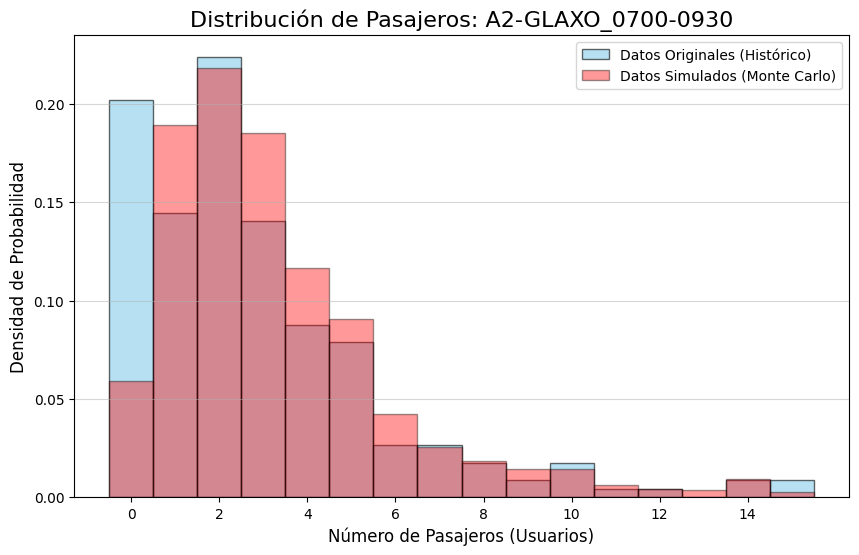

In [ ]:


# 1. Cargar los datos
df_simulacion = pd.read_csv('simulation_results.csv')
df_original = pd.read_csv('data_clean.csv')

# 2. Seleccionar un segmento clave
segmento_clave = 'A2-GLAXO_0700-0930'

# 3. Filtrar datos
pax_simulado = df_simulacion[df_simulacion['trayecto'] == segmento_clave]['usuarios_simulado']
pax_original = df_original[df_original['trayecto'] == 'A2-GLAXO']
pax_original['hora_salida'] = pd.to_datetime(pax_original['hora_salida'], format='%H:%M').dt.time

# Convertir las horas de inicio y fin del segmento a objetos time
from datetime import time
time_start = time.fromisoformat('07:00')
time_end = time.fromisoformat('09:30')

pax_original_segmento = pax_original.loc[
    (pax_original['hora_salida'] >= time_start) & 
    (pax_original['hora_salida'] < time_end)
]['Usuarios'].dropna()


# 4. Configurar el histograma
plt.figure(figsize=(10, 6))

# Calcular el número máximo de pasajeros para establecer los bins
max_pax = int(max(pax_simulado.max(), pax_original_segmento.max()))
bins = np.arange(-0.5, max_pax + 1.5, 1)

# Histograma de datos originales
plt.hist(
    pax_original_segmento, 
    bins=bins, 
    density=True, 
    alpha=0.6, 
    label='Datos Originales (Histórico)', 
    color='skyblue', 
    edgecolor='black'
)

# Histograma de datos simulados
plt.hist(
    pax_simulado, 
    bins=bins, 
    density=True, 
    alpha=0.4, 
    label='Datos Simulados (Monte Carlo)', 
    color='red', 
    edgecolor='black'
)

plt.title(f'Distribución de Pasajeros: {segmento_clave}', fontsize=16)
plt.xlabel('Número de Pasajeros (Usuarios)', fontsize=12)
plt.ylabel('Densidad de Probabilidad', fontsize=12)
plt.xticks(np.arange(0, max_pax + 1, 2))
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

In [ ]:

# Cargar los resultados de la simulación
df_simulacion = pd.read_csv('simulation_results.csv')

# --- Análisis del Tiempo de Viaje (Minutos) ---
time_analysis = df_simulacion.groupby('trayecto')['minutos_viaje_simulado'].agg(
    Media_Tiempo=np.mean,
    P95_Tiempo=lambda x: np.quantile(x, 0.95), # Usamos una lambda para el cuantil de forma segura
    Desviacion_Estandar_Tiempo=np.std
).reset_index()

# --- Análisis de Pasajeros (Usuarios) ---
pax_analysis = df_simulacion.groupby('trayecto')['usuarios_simulado'].agg(
    Media_Usuarios=np.mean,
    Max_Usuarios_Simulados=np.max
).reset_index()

# --- Consolidación del Reporte ---
reporte_final = pd.merge(time_analysis, pax_analysis, on='trayecto')

# Formateo y renombrado (igual que antes)
reporte_final['Media_Tiempo'] = reporte_final['Media_Tiempo'].round(2)
reporte_final['P95_Tiempo'] = reporte_final['P95_Tiempo'].round(2)
reporte_final['Desviacion_Estandar_Tiempo'] = reporte_final['Desviacion_Estandar_Tiempo'].round(2)
reporte_final['Media_Usuarios'] = reporte_final['Media_Usuarios'].round(2)

reporte_final.columns = [
    'Segmento',
    'Tiempo Promedio (min)',
    'Tiempo P95 (min) - Planificación',
    'Desviación Estándar (min)',
    'Pasajeros Promedio (Usuarios)',
    'Pasajeros Máximo Simulado (Usuarios)'
]

# Exportar el reporte final
output_report_file = 'reporte_montecarlo_final.csv'
reporte_final.to_csv(output_report_file, index=False)

print(f"\nReporte de Monte Carlo generado en '{output_report_file}'")
print("\n--- Vista Previa del Reporte de Optimización ---")
print(reporte_final)


Reporte de Monte Carlo generado en 'reporte_montecarlo_final.csv'

--- Vista Previa del Reporte de Optimización ---
                  Segmento  Tiempo Promedio (min)  \
0       A2-GLAXO_0600-0700                   8.32   
1       A2-GLAXO_0700-0930                   8.69   
2       A2-GLAXO_0930-1330                   7.43   
3       A2-GLAXO_1330-1800                   7.95   
4      DISNEY-A2_0600-0700                  14.46   
5      DISNEY-A2_0700-0930                  15.91   
6      DISNEY-A2_0930-1330                  14.32   
7      DISNEY-A2_1330-1800                  14.41   
8   GLAXO-DISNEY_0600-0700                   8.99   
9   GLAXO-DISNEY_0700-0930                  10.69   
10  GLAXO-DISNEY_0930-1330                  11.91   
11  GLAXO-DISNEY_1330-1800                  11.35   

    Tiempo P95 (min) - Planificación  Desviación Estándar (min)  \
0                              10.86                       1.52   
1                              12.50                       